In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Problem Intro

In this problem, we will implement key components of the Muon optimizer in PyTorch. Then,  we will compare Muon against SGD and AdamW empirically to demonstrate the benefits of Muon.

We will train a sample CNN architecture on CIFAR10 image data (initialized below).

In [ ]:
# Define a sample CNN for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Dataset & loader with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Increase batch size for more realistic training
batch_size = 128

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

## Part 1: Implementing Newton-Schulz

The core of Muon is using matrix orthogonalization on a typical gradient update matrix. After orthogonalization:
* Singular values become more uniform
* Updates act across all directions in parameter space
* The neural network can utilize its full parameter capacity (because parameters are all receiving nontrivial gradients)

In Muon, matrix orthogonalization is done using Newton-Schulz. Newton-Schulz relies on iteration using an odd matrix polynomial. In this problem, we consider a very simple cubic polynomial, but many odd polynomials can be used (state-of-the-art implementations use specific, tuned quintic polynomial).

**Complete the following code** to implement Newton-Schulz, using the matrix polynomial in the comments.


In [ ]:
def newton_schulz_orthogonalize(X: torch.Tensor, num_iters: int):
    """
    Apply Newton-Schulz iterations to approximate orthogonalization.

    This function applies the polynomial f(X) = (3X - X^3)/2 repeatedly to a normalized matrix,
    which gradually forces all singular values to 1 while preserving singular vectors.

    Args:
      X (torch.Tensor): Input matrix to orthogonalize
      num_iters (int): Number of Newton-Schulz iterations

    Returns:
      torch.Tensor: Orthogonalized matrix
    """
    dtype = X.dtype
    # Use bfloat16 for potential speed/memory savings during the iterations
    X = X.bfloat16()
    # Recall from prior homeworks that we can transpose the matrix to speed up computation.
    transposed = False
    if X.size(-2) < X.size(-1):
        transposed = True
        X = X.mT

    # Ensure spectral norm is at most sqrt(3)
    norm = torch.linalg.norm(X, dim=(-2, -1), keepdim=True)
    X = torch.div(X, norm + 1e-7) * (3**0.5)

    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    def f(X):
      return (3*X - X @ X.T @ X) / 2
    for _ in range(num_iters):
      X = f(X)
    ################################################################################

    if transposed:
        X = X.mT

    return X.to(dtype)

### Question 1

Notice that in the above implementation, we scale the spectral norm to be at most sqrt(3). **Can you explain why we choose this particular scaling?**

*(Hint: Inspect the roots of the cubic polynomial. What is the connection between the roots and the convergence properties of the singular values? You can refer to Discussion 4 for the answer)*

## Part 2: Implementing Muon Update

Now, we implement the update in a Muon optimizer. Given parameter matrix $W$ with momentum matrix $M$, the pseudocode for the Muon update proceeds as follows:

```
d_out, d_in = M.shape

# Apply Newton-Schulz orthogonalization
M ← newton_schulz_orthogonalize(M, ns_iters)
        
# Apply muP scaling factor for consistent update magnitude
M ← M · sqrt(max(1, d_out / d_in))
```

Then, the Muon update is used later to update the parameters W:
```
# Update the parameter matrix
W  ← W - lr * M
```

**Complete the following code** to implement the Muon update following the above pseudocode.

In [ ]:
import torch.optim as optim

def muon_update(grad, momentum, beta=0.95, ns_iters=5):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    ################################################################################
    # TODO: YOUR CODE HERE
    ################################################################################
    d_out, d_in = update.shape
    update = newton_schulz_orthogonalize(update, ns_iters)
    update = update * torch.sqrt(torch.tensor(max(1, d_out / d_in)))
    ################################################################################

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class Muon(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, ns_iters=5,
                weight_decay=0):

        defaults = dict(lr=lr, beta=beta, ns_iters=ns_iters,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            ns_iters = group['ns_iters']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update(grad, state['momentum'],
                                         beta=beta, ns_iters=ns_iters)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None

### Question 2

Note that Muon requires that parameters are 2D matrices of shape $d_{out} \times d_{in}$. However, we know that parameters that are convolutional kernels have shape $c_{out} \times c_{in} \times k \times k$ where $c$ denotes number of channels and $k$ is kernel size.

Modern implementations of convolutional layers will transform an input image $\mathbf{x}$ of shape $c_{in} \times h \times w$ to $\mathbf{x}'$ such that each column has size $c_{in} \cdot k \cdot k$ and corresponds to one flattened "receptive field" of the image (or one patch of the image that a convolutional filter passes over to compute one pixel in the output).

Given this fact, **how do we modify the convolutional kernel into a $d_{out} \times d_{in}$ matrix $C$ such that the output of the convolutional layer can be expressed as $C \mathbf{x}'$**.


## Part 3: Empirical Evaluation of Muon

Now, we'll train the CNN network on the CIFAR10 dataset using our Muon implementation, comparing performance on the test set against other popular optimizers in SGD and AdamW.

First, in addition to SGD and AdamW, we consider two additional baseline optimizers that will help us better interpret our results:


*   MuonSVD: Rather than using Newton-Schulz, we orthogonalize the momentum using SVD on the momentum matrix $M = U\Sigma V^T$ and computing $UV^T$.
*   AdamWMuP: We add the muP scaling on top of the AdamW optimizer. This is meant the help us better understand how much of the Muon performance is due to the orthogonalization step, and how much is simply from the muP scaling.

The cell below implements these two additional optimizers. You do not have to implement anything.





In [ ]:
import torch.optim as optim

def muon_update_svd(grad, momentum, beta=0.95):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Orthogonalization via SVD - specify full_matrices=False for reduced SVD
    U, _, Vh = torch.linalg.svd(update, full_matrices=False)
    update = torch.matmul(U, Vh)

    # Apply muP scaling
    update.mul_(max(1, update.size(-2) / update.size(-1))**0.5)

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class MuonSVD(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, weight_decay=0):

        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update_svd(grad, state['momentum'], beta=beta)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None


class AdamWMuP(optim.Optimizer):
    def __init__(self,  params, lr=0.01, betas=(0.9, 0.999), weight_decay=0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']

            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1 - group["betas"][0])
                v = state['variance']
                v.lerp_(grad**2, 1 - group["betas"][1])

                m_hat = m / (1 - group["betas"][0]**state['step'])
                v_hat = v / (1 - group["betas"][1]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                if p.ndim >= 2:
                    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
                    original_shape = u.shape
                    reshaped = False
                    if u.ndim > 2:
                        u = u.view(u.shape[0], -1)  # keep first dim, flatten the rest
                        reshaped = True

                    u.mul_(max(1, u.size(-2) / u.size(-1))**0.5)

                    # Unflatten back to convolutional kernel
                    if reshaped:
                        u = u.view(original_shape)

                p.add_(u, alpha=-lr)

        return None


If you performed hyperparameter sweeping (optional part below), then replace the default hyperparameters with the values you found from your sweep. Then, run the following cell to investigate how good Muon is relative to other baseline optimizers. The cell should take less than 10 minutes if you use a GPU runtime on Colab.

In [ ]:
# # --- Define the optimizers you want to compare ---
# optimizers_dict = {
#     "Muon": lambda params: Muon(params, lr=1e-2, weight_decay=0),
#     "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=1e-4),
#     "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-3),
#     "MuonSVD": lambda params: MuonSVD(params, lr=1e-2, weight_decay=0),
#     "AdamWMuP": lambda params: AdamWMuP(params, lr=1e-3, weight_decay=1e-3)
# }

# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda:1")
# criterion = nn.CrossEntropyLoss()

# # Function to evaluate model
# def evaluate(model, dataloader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return 100 * correct / total


# results = {}  # store loss curves
# accuracy_results = {}  # store accuracy curves

# # --- Train for each optimizer ---
# for opt_name, opt_fn in optimizers_dict.items():
#     print(f"\n--- Training with {opt_name} ---")
#     model = CIFAR10CNN().to(device)  # re-init model each time
#     optimizer = opt_fn(model.parameters())

#     # Learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

#     losses = []
#     accuracies = []
#     epoch_times = []

#     for epoch in range(1, 6):  # Train for 5 epochs
#         model.train()
#         epoch_start_time = time.time()
#         total_loss = 0

#         for i, (x, y) in enumerate(train_loader):
#             x, y = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             out = model(x)
#             loss = criterion(out, y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#             # Print progress
#             if (i+1) % 100 == 0:
#                 print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

#         epoch_end_time = time.time()
#         epoch_duration = epoch_end_time - epoch_start_time
#         epoch_times.append(epoch_duration)

#         # Evaluate
#         test_acc = evaluate(model, test_loader)

#         avg_loss = total_loss / len(train_loader)
#         losses.append(avg_loss)
#         accuracies.append(test_acc)

#         print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

#         # Update learning rate
#         scheduler.step()

#     results[opt_name] = losses
#     accuracy_results[opt_name] = accuracies

#     # Calculate and print total training time
#     total_time = sum(epoch_times)
#     print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# # --- Plot results ---
# # 1. Loss vs Epoch
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# for opt_name, losses in results.items():
#     plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
# plt.xlabel("Epoch")
# plt.ylabel("Average Loss")
# plt.title("Training Loss vs Epoch for Different Optimizers")
# plt.legend()
# plt.grid(True)

# # 2. Accuracy vs Epoch
# plt.subplot(1, 2, 2)
# for opt_name, accuracies in accuracy_results.items():
#     plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy (%)")
# plt.title("Test Accuracy vs Epoch for Different Optimizers")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

### Question 3

**Which optimizer performed best between Muon, SGD, and AdamW?** Also **copy the resulting plots** into the submission as well.

### Question 4

Compare the loss curves between Muon and MuonSVD. **Are the results expected? Explain why.**

### Question 5

The Muon optimizer contains two key differences: (1) orthogonalization of the momentum, and (2) muP scaling of the momentum. **Between orthogonalization and muP scaling, which seemed to matter more?** Reference the loss curves to justify your answer.  

### Question 6 (Optional)

Our implementation of Newton-Schulz is suboptimal in the polynomial used for convergence.
The community has developed quintic polynomials that converge faster while still being efficient. **Implement an improved Newton-Schulz and compare. Comment on the speed advantage of the improved Muon relative to the MuonSVD.**

*(Hint: You can modify the number of iterations by setting the ns_iters parameter in the Muon optimizer)*

## Part 4 (Optional): Hyperparameter sweeps (Muon & AdamW)

To ensure that we are making fair comparisons, we will sweep over both learning rate and weight decay for both Muon and AdamW (the likely strongest competing optimizer). We choose these two parameters because empirically, they have the greatest effect on training.

Running the sweep should take less than 1 hour total on a GPU runtime.

In [ ]:
# from torch.utils.data import random_split

# # device = "cuda" if torch.cuda.is_available() else "cpu"
# criterion = nn.CrossEntropyLoss()

# # Function to evaluate model
# def evaluate(model, dataloader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     return 100 * correct / total


# def train_and_evaluate(optimizer_fn, lr, weight_decay, num_epochs=5):
#     """Trains and evaluates the CIFAR10CNN with a given optimizer and hyperparameters."""
#     model = CIFAR10CNN().to(device)
#     optimizer = optimizer_fn(model.parameters(), lr=lr, weight_decay=weight_decay)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

#     best_accuracy = 0

#     # Split training data into training and validation sets
#     train_size = int(0.8 * len(train_ds))
#     val_size = len(train_ds) - train_size
#     train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])

#     train_loader_split = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


#     for epoch in range(1, num_epochs + 1):
#         model.train()
#         for i, (x, y) in enumerate(train_loader_split):
#             x, y = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             out = model(x)
#             loss = criterion(out, y)
#             loss.backward()
#             optimizer.step()

#         # Evaluate on the validation set
#         val_acc = evaluate(model, val_loader)
#         best_accuracy = max(best_accuracy, val_acc)

#         scheduler.step()

#     return best_accuracy

# # Define the optimizers and their hyperparameter search spaces
# optimizers_to_sweep = {
#     "Muon": {
#         "optimizer_fn": lambda params, lr, weight_decay: Muon(params, lr=lr, weight_decay=weight_decay),
#         "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
#         "weight_decay_values": [0, 1e-4, 1e-3]
#     },
#     "AdamW": {
#         "optimizer_fn": lambda params, lr, weight_decay: torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay),
#         "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
#         "weight_decay_values": [0, 1e-4, 1e-3]
#     }
# }

# results = {}

# # Perform the hyperparameter sweep for each optimizer
# for opt_name, opt_info in optimizers_to_sweep.items():
#     print(f"\n--- Hyperparameter sweep for {opt_name} ---")
#     optimizer_fn = opt_info["optimizer_fn"]
#     lr_values = opt_info["lr_values"]
#     weight_decay_values = opt_info["weight_decay_values"]

#     results[opt_name] = {}

#     for lr in lr_values:
#         for weight_decay in weight_decay_values:
#             print(f"Training with lr={lr}, weight_decay={weight_decay}")
#             accuracy = train_and_evaluate(optimizer_fn, lr, weight_decay)
#             results[opt_name][(lr, weight_decay)] = accuracy
#             print(f"Validation Accuracy: {accuracy:.2f}%")

# # Print the results and best hyperparameters for each optimizer
# print("\n--- Hyperparameter Sweep Results ---")
# for opt_name, opt_results in results.items():
#     print(f"\n{opt_name}:")
#     for (lr, weight_decay), accuracy in opt_results.items():
#         print(f"  (lr={lr}, weight_decay={weight_decay}): {accuracy:.2f}%")

#     best_params = max(opt_results, key=opt_results.get)
#     print(f"Best hyperparameters for {opt_name}: (lr={best_params[0]}, weight_decay={best_params[1]}) with validation accuracy {opt_results[best_params]:.2f}%")

### Question 7 (Optional)

**What were the best choices for hyperparameters for Muon? What about for AdamW?**

# New questions by (Nicolas Rault-Wang, nraultwang@berkeley.edu)

## Part 5: The Polar Express (Muon Variant)

In this section, we will implement the 2025  [**Polar Express**](https://arxiv.org/abs/2505.16932) method, a state-of-the-art algorithm for computing the polar decomposition within the Muon optimizer.

Standard Muon typically relies on Newton-Schulz iteration to orthogonalize the update matrix. Newton-Schulz uses a static polynomial at every step (usually degree 3: $p(X) = 1.5X - 0.5X X^\top X$). While effective asymptotically, it suffers from slow initial convergence 3and can be unstable in low precision (like `bfloat16`) because intermediate singular values may overshoot the range $[-1, 1]$, causing sign flips.

**Polar Express** improves this by using a dynamic schedule of polynomial coefficients that changes at each iteration $k$. These coefficients are pre-calculated offline by solving a minimax optimization problem, ensuring the polynomial optimally approximates the sign function over the matrix's spectrum at that specific step.

This approach guarantees the fastest possible worst-case convergence (super-exponential) while maintaining GPU efficiency. The update typically uses a degree-5 polynomial implemented efficiently with nested matrix multiplications:
$$X_{k+1} = X_k (\alpha_k I + X_k^\top X_k (\beta_k I + \gamma_k X_k^\top X_k))$$
Where:
- $X_k$ is the current approximate polar factor.
- $\alpha_k, \beta_k, \gamma_k$ are the optimal coefficients for step $k$, pre-computed to maximize spectral steering speed while preventing numerical instability in `bfloat16`.

### **Question 8: Implementation**
Implement the `PolarExpress` subroutine below. We have provided the helper function `optimal_composition` (which calculates the coefficients). Your task is to implement the iterative update loop using efficient matrix multiplication.

**Note:** We have provided the `MuonPolarExpress` optimizer class and `muon_polar_update` function for you. You only need to complete the `polar_express_orthogonalize` function.

In [ ]:
import torch
from itertools import repeat
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from itertools import repeat
from math import inf, sqrt
import numpy as np

torch.manual_seed(42)

In [ ]:
"""
MIT License

Copyright (c) 2025 Noah Amsel

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

def optimal_quintic(l, u):
    assert 0 <= l <= u
    if 1 - 5e-6 <= l / u:
        # Above this threshold, the equioscillating polynomials
        # is numerically equal to...
        return (15/8)/u, (-10/8)/(u**3), (3/8)/(u**5)
    # This initialization becomes exact as l -> u
    q = (3*l + 1) / 4
    r = (l + 3) / 4
    E, old_E = inf, None
    while not old_E or abs(old_E - E) > 1e-15:
        old_E = E
        LHS = np.array([
            [l, l**3, l**5, 1],
            [q, q**3, q**5, -1],
            [r, r**3, r**5, 1],
            [u, u**3, u**5, -1],
        ])
        a, b, c, E = np.linalg.solve(LHS, np.ones(4))
        q, r = np.sqrt((-3*b + np.array([-1, 1]) *
                        sqrt(9*b**2 - 20*a*c)) / (10*c))
    return float(a), float(b), float(c)

target_slope = 0
def obj(l):
    a, b, c = optimal_quintic(l, 1)
    total = (a+b+c)
    a /= total; b /= total; c /= total
    local_argmin = np.sqrt((-3*b + sqrt(9*b**2 - 20*a*c)) / (10*c))
    local_min = a*local_argmin + b*local_argmin**3 + c*local_argmin**5
    return local_min / local_argmin - target_slope


def optimal_composition(l, num_iters, safety_factor_eps=0, cushion=0):
    u = 1
    assert 0 <= l <= u
    safety_factor = 1 + safety_factor_eps
    coefficients = []
    for iter in range(num_iters):
        a, b, c = optimal_quintic(max(l, cushion*u), u)
        if cushion*u > l:
            # Due to cushioning, this may be centered around 1 with
            # respect to 0.024*u, u. Recenter it around 1 with respect
            # to l, u, meaning find c so that 1 - c*p(l) = c*p(u) - 1:
            pl = a*l + b*l**3 + c*l**5
            pu = a*u + b*u**3 + c*u**5
            rescaler = 2/(pl + pu)
            a *= rescaler; b *= rescaler; c *= rescaler
        # Optionally incorporate safety factor here:
        if iter < num_iters - 1:  # don't apply to last polynomial
            a /= safety_factor; b /= safety_factor**3; c /= safety_factor**5
        coefficients.append((a, b, c))
        l = a*l + b*l**3 + c*l**5
        u = 2 - l
    return coefficients

In [ ]:
# Compute the optimal polynomial coefficients for Polar Express.
# (This logic is pre-solved for you to focus on the optimizer step)
# We use l=1e-3 as a conservative lower bound estimate for singular values

coeffs_list = optimal_composition(l=1e-3, num_iters=10, safety_factor_eps=1e-2, cushion=0.02)


# --- TODO: Implement Polar Express ---
def polar_express_orthogonalize(G: torch.Tensor, steps: int) -> torch.Tensor:
    """
    Applies the Polar Express iterative method to orthogonalize matrix G.
    """
    assert G.ndim >= 2
    X = G.bfloat16()  # for speed

    # Efficiency Trick 1: Work with the smaller dimension
    if G.size(-2) > G.size(-1): X = X.mT

    # Pre-conditioning: Normalize spectral norm estimate
    X = X / (X.norm(dim=(-2, -1), keepdim=True) * 1.01 + 1e-7)

    # Prepare coefficients
    hs = coeffs_list[:steps] + list(repeat(coeffs_list[-1], steps - len(coeffs_list)))

    for a, b, c in hs:
        ################################################################################
        # TODO: Implement the update X <- a*X + b*X^3 + c*X^5
        #
        # Efficiency Trick 2: Reuse the Gram matrix A = X @ X.mT
        #
        # Note: X^3 = (X @ X.mT) @ X = A @ X
        #       X^5 = (X @ X.mT) @ (X @ X.mT) @ X = (A @ A) @ X
        ################################################################################
        # ___________ YOUR CODE HERE ____________
        X = ...
        ################################################################################

    # Restore orientation if we transposed earlier
    if G.size(-2) > G.size(-1): X = X.mT
    return X

In [ ]:
## SOLUTION
def polar_express_orthogonalize(G: torch.Tensor, steps: int) -> torch.Tensor:
    assert G.ndim >= 2
    X = G.bfloat16()  # for speed
    if G.size(-2) > G.size(-1): X = X.mT  # this reduces FLOPs
    X = X / (X.norm(dim=(-2, -1), keepdim=True) * 1.01 + 1e-7)

    hs = coeffs_list[:steps] + list(repeat(coeffs_list[-1], steps - len(coeffs_list)))

    for a, b, c in hs:
        # Solution
        A = X @ X.mT
        B = b * A + c * A @ A
        X = a * X + B @ X  # X <- aX + bX^3 + cX^5

    if G.size(-2) > G.size(-1): X = X.mT
    return X

In [ ]:
# --- Provided: MuonPolarExpress Optimizer Wrapper ---
def muon_polar_update(grad, momentum, beta=0.95, ns_iters=5):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Use Polar Express instead of Newton Schulz to orthogonalize
    update = polar_express_orthogonalize(update, ns_iters)

    d_out, d_in = update.shape
    update = update * torch.sqrt(torch.tensor(max(1, d_out / d_in)))

    if reshaped:
        update = update.view(original_shape)

    return update

class MuonPolarExpress(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, ns_iters=5, weight_decay=0):
        defaults = dict(lr=lr, beta=beta, ns_iters=ns_iters, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            ns_iters = group['ns_iters']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad
                state = self.state[p]
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                if p.ndim >= 2:
                    # Call the MuonPolar specific update
                    update = muon_polar_update(grad, state['momentum'], beta=beta, ns_iters=ns_iters)
                    p.add_(update, alpha=-lr)
                else:
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)
        return None

## Part 6: The Lion Optimizer

[**Lion**](https://arxiv.org/abs/2302.06675) (EvoLved Sign Momentum) is a memory-efficient optimizer discovered through symbolic program search. Unlike AdamW, which tracks both momentum (first moment) and variance (second moment), Lion only tracks momentum, halving the memory footprint of the optimizer state.

Lion relies on the sign operation to calculate updates, ensuring that all parameter updates have a uniform magnitude determined solely by the learning rate.

Let $\theta$ be the parameters, $g_t$ be the gradient, $\eta$ be the learning rate, and $\lambda$ be the weight decay coefficient. The update process typically performs decoupled weight decay first, followed by the parameter update:

1. Decoupled Weight Decay:$$\theta_t \leftarrow \theta_{t-1} (1 - \eta \lambda)$$
2. Calculate Update Candidate (Interpolation of Gradient and Momentum):$$c_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
3. Update Parameters (using Sign):$$\theta_t \leftarrow \theta_t - \eta \cdot \text{sign}(c_t)$$
4. Update Momentum (EMA):$$m_t = \beta_2 m_{t-1} + (1-\beta_2)g_t$$

### **Question 10: Implement Lion**
Fill in the missing lines in the `Lion` optimizer class below.

In [ ]:
class Lion(optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr: raise ValueError(f"Invalid learning rate: {lr}")
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue

                # Extract parameters
                grad = p.grad
                lr = group['lr']
                wd = group['weight_decay']
                beta1, beta2 = group['betas']

                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                ################################################################################
                # TODO: Implement the Lion Update Step
                #
                # 1. Perform Decoupled Weight Decay
                #    Update 'p' in-place.
                #    Math: p = p * (1 - lr * wd)
                #
                # 2. Compute the Update Candidate (c_t)
                #    This uses the current gradient and the PREVIOUS momentum (exp_avg).
                #    Math: c_t = beta1 * exp_avg + (1 - beta1) * grad
                #
                # 3. Apply the Parameter Update using Sign
                #    Update 'p' in-place.
                #    Math: p = p - lr * sign(c_t)
                #
                # 4. Update the Momentum Buffer (exp_avg)
                #    Update 'exp_avg' in-place using the current gradient.
                #    Math: exp_avg = beta2 * exp_avg + (1 - beta2) * grad
                ################################################################################

                # ___________ YOUR CODE HERE ____________

                ################################################################################

        return loss

In [ ]:
# SOLUTION

class Lion(optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr: raise ValueError(f"Invalid learning rate: {lr}")
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue

                # Extract parameters
                grad = p.grad
                lr = group['lr']
                wd = group['weight_decay']
                beta1, beta2 = group['betas']

                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                # 1. Perform Decoupled Weight Decay
                if wd > 0:
                    p.data.mul_(1 - lr * wd)

                # 2. Compute the Update Candidate (c_t)
                # We calculate this separately so we don't modify exp_avg yet
                c_t = exp_avg * beta1 + grad * (1 - beta1)

                # 3. Apply the Parameter Update using Sign
                p.add_(torch.sign(c_t), alpha=-lr)

                # 4. Update the Momentum Buffer (exp_avg)
                # Update stored momentum for the NEXT step
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

        return loss

## Part 7: Evaluating MuonPolarExpress and Lion

Run the code below to evaluate your new optimizers (**MuonPolarExpress**, **Lion**) against the (calibrated) baselines (**Muon**, **AdamW**).


--- Training with MuonPolarExpress ---
Epoch [1/5], Step [100/391], Loss: 1.6493
Epoch [1/5], Step [200/391], Loss: 1.3834
Epoch [1/5], Step [300/391], Loss: 1.2026
MuonPolarExpress | Epoch 1, avg loss: 1.4420, test acc: 66.92%, time: 4.32 seconds
Epoch [2/5], Step [100/391], Loss: 1.2781
Epoch [2/5], Step [200/391], Loss: 1.1118
Epoch [2/5], Step [300/391], Loss: 0.9515
MuonPolarExpress | Epoch 2, avg loss: 0.9852, test acc: 72.03%, time: 4.04 seconds
Epoch [3/5], Step [100/391], Loss: 0.9291
Epoch [3/5], Step [200/391], Loss: 0.9914
Epoch [3/5], Step [300/391], Loss: 0.7794
MuonPolarExpress | Epoch 3, avg loss: 0.8223, test acc: 77.43%, time: 3.63 seconds
Epoch [4/5], Step [100/391], Loss: 0.7143
Epoch [4/5], Step [200/391], Loss: 0.6739
Epoch [4/5], Step [300/391], Loss: 0.6470
MuonPolarExpress | Epoch 4, avg loss: 0.6910, test acc: 79.70%, time: 3.31 seconds
Epoch [5/5], Step [100/391], Loss: 0.5462
Epoch [5/5], Step [200/391], Loss: 0.6934
Epoch [5/5], Step [300/391], Loss: 0.635

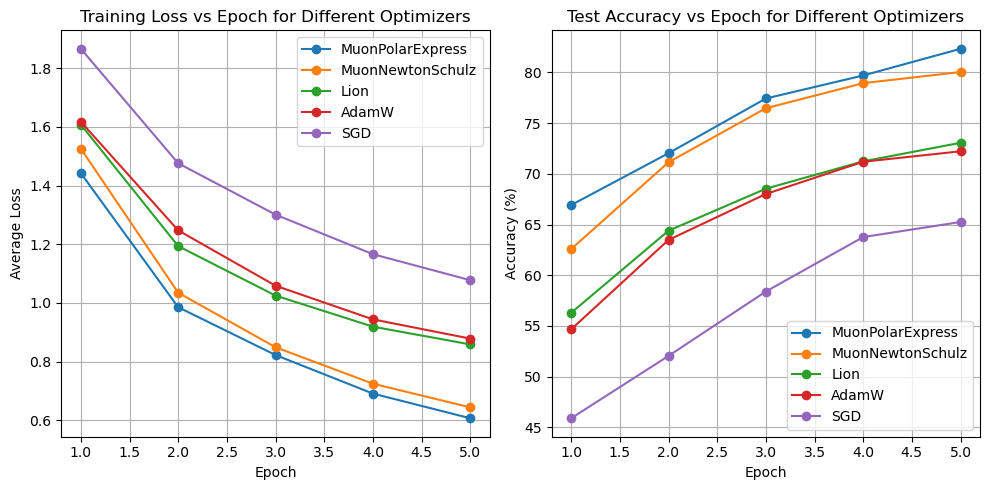

In [ ]:
# Define optimizers to compare
optimizers_dict = {
    "MuonPolarExpress": lambda params: MuonPolarExpress(params, lr=1e-2, weight_decay=1e-1),
    "MuonNewtonSchulz": lambda params: Muon(params, lr=1e-2, weight_decay=1e-4),

    "Lion": lambda params: Lion(params, lr=5e-4, weight_decay=0),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=0),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=1e-4),
}

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda:1")
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


results = {}  # store loss curves
accuracy_results = {}  # store accuracy curves

# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 2, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Question 11**
Based on the plots and best validation accuracy:
1.  How does **MuonPolarExpress** compare to standard **Muon**? Did the optimized polynomials provide better stability or faster initial convergence?
2.  How did **Lion** compare to **AdamW**?

### **Question 11 [SOLUTION]**
Based on the plots and best validation accuracy:
1.  How does **MuonPolarExpress** compare to standard **Muon**? Did the optimized polynomials provide better stability or faster initial convergence?


    MuonPolarExpress performed better. The use of optimized, dynamic polynomials provided faster initial convergence compared to standard Muon (Newton-Schulz). By solving a minimax problem at each step, Polar Express steers singular values toward $\pm 1$ more efficiently than the static coefficients used in standard Muon.
2.  How did **Lion** compare to **AdamW**?

    Lion generally achieved higher validation accuracy. While AdamW is highly robust, Lion is often shown to reach lower validation loss faster, particularly in large-batch or large-scale regimes.

## Part 8 (Optional): Hyperparameter sweeps (MuonPolarExpress & Lion)

To ensure that we are making fair comparisons, we will sweep over both learning rate and weight decay for both MuonPolarExpress and Lion.

Running the sweep should take less than 1 hour total on a GPU runtime.

In [ ]:
# Define the optimizers and their hyperparameter search spaces
# Grid to search
optimizers_to_sweep_pe_and_lion = {
    # "MuonPolarExpress": {
    #     "optimizer_fn": lambda params, lr, weight_decay: MuonPolarExpress(params, lr=lr, weight_decay=weight_decay),
    #     "lr_values": torch.linspace(1e-1, 1e-3, 5),
    #     "weight_decay_values": torch.linspace(0, 1e-4, 5)
    # },
    "Lion": {
        "optimizer_fn": lambda params, lr, weight_decay: Lion(params, lr=lr, weight_decay=weight_decay),
        "lr_values": torch.linspace(1e-3, 1e-4, 6),
        "weight_decay_values": torch.linspace(0, 0.3, 3)
    }
}



results_pe_lion = {}

print("Starting Hyperparameter Sweep...")

# Perform the hyperparameter sweep for each optimizer
for opt_name, opt_info in optimizers_to_sweep_pe_and_lion.items():
    print(f"\n--- Hyperparameter sweep for {opt_name} ---")
    optimizer_fn = opt_info["optimizer_fn"]
    lr_values = opt_info["lr_values"]
    weight_decay_values = opt_info["weight_decay_values"]

    results_pe_lion[opt_name] = {}

    for lr in lr_values:
        for weight_decay in weight_decay_values:
            print(f"Training with lr={lr}, weight_decay={weight_decay}")
            accuracy = train_and_evaluate(optimizer_fn, lr, weight_decay)
            results_pe_lion[opt_name][(lr, weight_decay)] = accuracy
            print(f"Validation Accuracy: {accuracy:.2f}%")

# Print the results and best hyperparameters for each optimizer
print("\n--- Hyperparameter Sweep Results ---")
for opt_name, opt_results in results_pe_lion.items():
    print(f"\n{opt_name}:")
    for (lr, weight_decay), accuracy in opt_results.items():
        print(f"  (lr={lr}, weight_decay={weight_decay}): {accuracy:.2f}%")

    best_params = max(opt_results, key=opt_results.get)
    print(f"Best hyperparameters for {opt_name}: (lr={best_params[0]}, weight_decay={best_params[1]}) with validation accuracy {opt_results[best_params]:.2f}%")

### Optimal Lion and MuonPolar hyperparameters [SOLUTION]
`MuonPolar: 78.20% with params (0.01, 0.1)`

`Lion: 69.04% with params (1e-5, 0)`